<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/NLEMalariaMicroscopy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Weights And Bias Install, Iniatilisation and Configuration

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
# !wandb login
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Malaria-Detection", entity="nlemalariamicroscopy")

wandb: Currently logged in as: atbrian20 (nlemalariamicroscopy). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 5,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
##DATA PREPARATION

#DATA LOADING

In [ ]:
#Removing the duplicates from the dataset
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import imagehash
import os
from tqdm import tqdm

def find_duplicates(folder_path):
    image_hashes = {}
    duplicates = []

    for filename in tqdm(os.listdir(folder_path), desc="Hashing images"):
        file_path = os.path.join(folder_path, filename)

        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            with open(file_path, 'rb') as f:
                img_hash = imagehash.average_hash(Image.open(f))

            if img_hash not in image_hashes:
                image_hashes[img_hash] = file_path
            else:
                duplicates.append(file_path)

    return duplicates

def remove_duplicates(duplicates):
    for duplicate in tqdm(duplicates, desc="Removing duplicates"):
        os.remove(duplicate)

dataset_path = "/content/drive/MyDrive/images/"

duplicate_files = find_duplicates(dataset_path)


print(f"Number of duplicate images found: {len(duplicate_files)}")
remove_duplicates(duplicate_files)


Hashing images: 100%|██████████| 2713/2713 [01:15<00:00, 35.87it/s]


Number of duplicate images found: 34


Removing duplicates: 100%|██████████| 34/34 [00:00<00:00, 555.17it/s]


In [ ]:
import os
import cv2

def resize_images(input_folder, output_folder, target_size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(input_path)

            resized_img = cv2.resize(img, target_size)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_img)

input_dataset_path = "/content/drive/MyDrive/images/"


output_dataset_path = "/content/drive/MyDrive/resized_images/"

target_size = (224, 224)

resize_images(input_dataset_path, output_dataset_path, target_size)


In [ ]:
import os
import cv2
import numpy as np

def normalize_images(input_folder, output_folder, target_size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(input_path)
            resized_img = cv2.resize(img, target_size)

            # Normalize pixel values to the range [0, 1]
            normalized_img = resized_img.astype(np.float32) / 255.0

            # Save the normalized image to the output folder
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, (normalized_img * 255).astype(np.uint8))

input_dataset_path = "/content/drive/MyDrive/resized_images/"

output_dataset_path = "/content/drive/MyDrive/normalized_images/"  # Update this path to the desired output folder

# Specify the target size for resizing
target_size = (224, 224)

# Normalize images
normalize_images(input_dataset_path, output_dataset_path, target_size)


In [ ]:
import os

def remove_files_with_extension(folder_path, target_extension):
    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file has the target extension
        if filename.endswith(target_extension):
            # Remove the file
            os.remove(file_path)
            print(f"Removed: {file_path}")

# Specify the path to your folder
folder_path = "/content/drive/MyDrive/annotation/"

# Specify the target extension to remove
target_extension = "(1).xml"

# Remove files with the specified extension
remove_files_with_extension(folder_path, target_extension)

Removed: /content/drive/MyDrive/annotation/plasmodium-0537 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0536 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0532 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0534 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0535 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0530 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0538 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0533 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0539 (1).xml
Removed: /content/drive/MyDrive/annotation/plasmodium-0531 (1).xml


In [ ]:
import os

def remove_files_with_extension(folder_path, target_extension):
    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file has the target extension
        if filename.endswith(target_extension):
            # Remove the file
            os.remove(file_path)
            print(f"Removed: {file_path}")

# Specify the path to your folder
folder_path = "/content/drive/MyDrive/annotation/"

# Specify the target extension to remove
target_extension = " (1).xml"

# Remove files with the specified extension
remove_files_with_extension(folder_path, target_extension)

In [ ]:
import os

def remove_files_with_suffix(directory, suffix):
    for filename in os.listdir(directory):
        if filename.endswith(suffix):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)

# Specify the path to your directory
directory_path = "/content/drive/MyDrive/normalized_images/"
  # Update this path to the actual path of your directory

# Specify the suffix you want to remove
suffix_to_remove = " (1).jpg"

# Remove files with the specified suffix
remove_files_with_suffix(directory_path, suffix_to_remove)


In [ ]:
import os
import cv2

image_folder = "/content/drive/MyDrive/normalized_images/"
annotation_folder = "/content/drive/MyDrive/annotation"

image_files = os.listdir(image_folder)

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    annotation_path = os.path.join(annotation_folder, image_file.replace(".jpg", ".xml"))  # Adjust the file extension if needed

    # Load image
    image = cv2.imread(image_path)

    # Load annotation data (customize based on your annotation format)
    with open(annotation_path, 'r') as annotation_file:
        annotation_data = annotation_file.read()


# Continue with your preprocessing and model training stepsa


In [ ]:
import os
import shutil
import random

def split_dataset(input_folder, output_folder, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Create output folders for training, validation, and test sets
    train_folder = os.path.join(output_folder, 'train')
    val_folder = os.path.join(output_folder, 'val')
    test_folder = os.path.join(output_folder, 'test')

    for folder in [train_folder, val_folder, test_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Ensure the file is an image (you may need to adjust the list of valid extensions)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Generate a random number to determine which set the image belongs to
            rand_num = random.random()

            if rand_num < train_ratio:
                shutil.copy(file_path, os.path.join(train_folder, filename))
            elif rand_num < train_ratio + val_ratio:
                shutil.copy(file_path, os.path.join(val_folder, filename))
            else:
                shutil.copy(file_path, os.path.join(test_folder, filename))

# Specify the path to your input dataset
input_dataset_path = "/content/drive/MyDrive/normalized_images/" # Update this path to the actual path of your "images" dataset folder

# Specify the path to your output dataset
output_dataset_path = "/content/drive/MyDrive/normalized_images/"  # Update this path to the desired output folder

# Specify the ratios for training, validation, and test sets
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Split the dataset
split_dataset(input_dataset_path, output_dataset_path, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


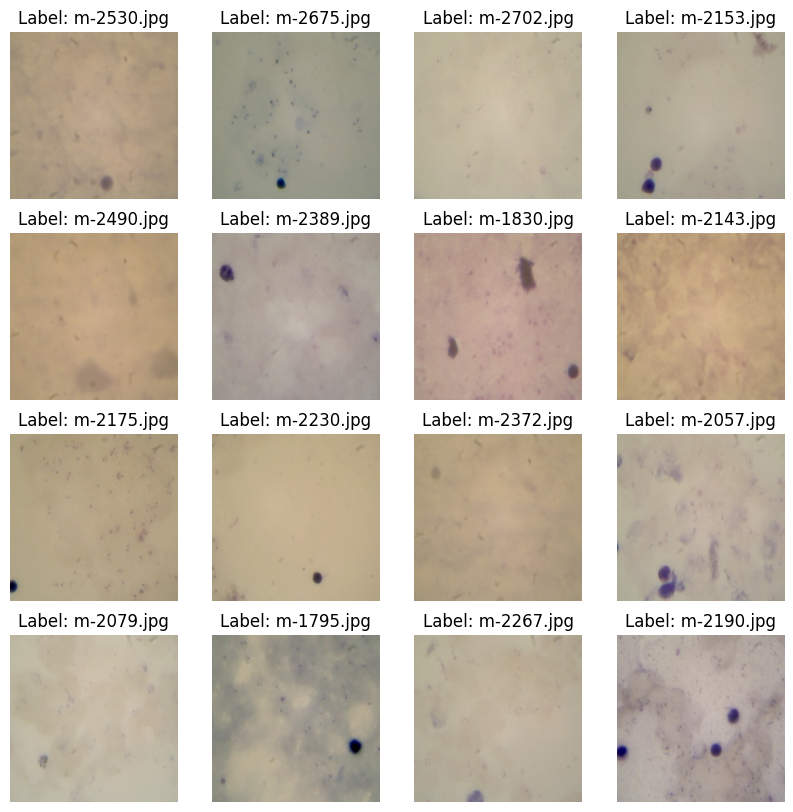

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def extract_label_from_filename(filename):
    label = filename[-10:]
    return label
# Specify the path to your dataset
dataset_path = "/content/drive/MyDrive/normalized_images/train"  # Update this path to the actual path of your dataset

# List all image files in the dataset folder
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Take a subset of images for visualization (adjust as needed)
subset_images = image_files[:16]

# Plot the images
plt.figure(figsize=(10, 10))
for i, filename in enumerate(subset_images):
    image_path = os.path.join(dataset_path, filename)
    image = Image.open(image_path)

    # Assuming the label is extracted from the filename or some other logic
    label = extract_label_from_filename(filename)

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()


In [ ]:
  ## Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
!pip install tensorflow matplotlib
!pip install opencv-python

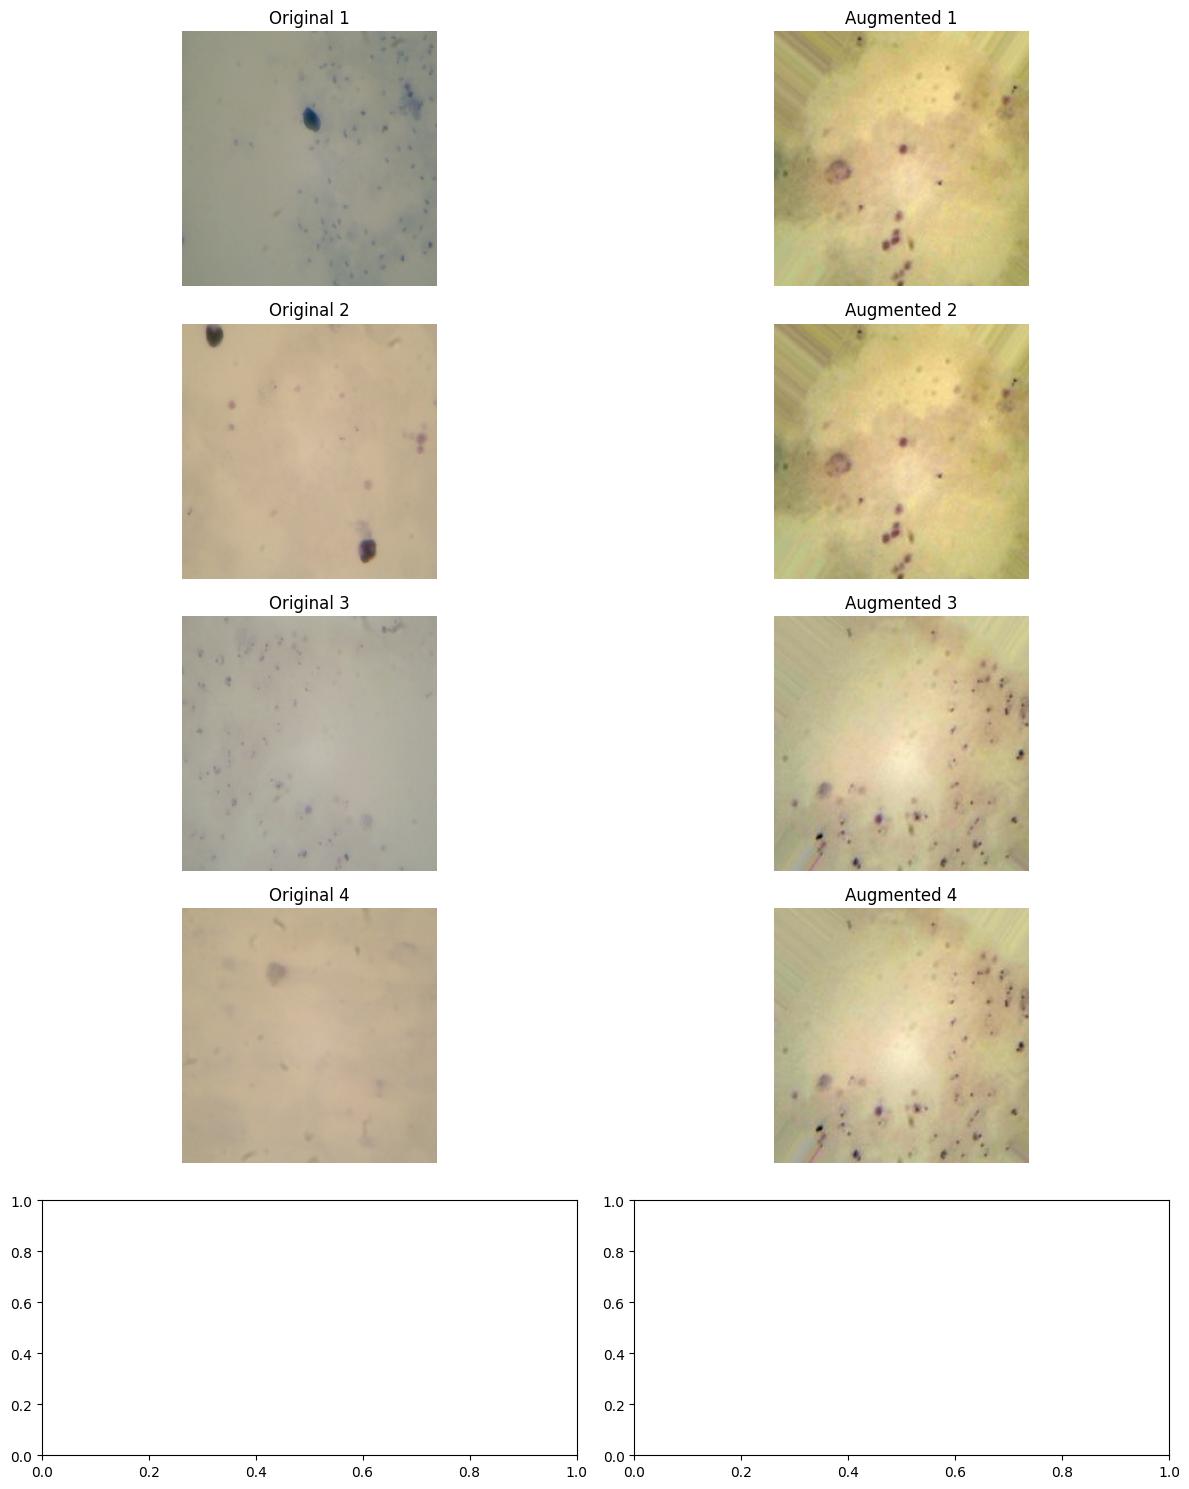

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Set a random seed for reproducibility
np.random.seed(42)

# Define your dataset directory and output directory for augmented images
dataset_dir = "/content/drive/MyDrive/normalized_images/train"
output_dir = "/content/drive/MyDrive/normalized_images/train/augmented_dataset"

# Make sure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalize pixel values
)

# List all images in your dataset directory
images = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

# Choose a few images for visualization
sample_images = np.random.choice(images, 4, replace=False)

# Visualize the original and augmented images
fig, axes = plt.subplots(5, 2, figsize=(12, 15))
axes = axes.flatten()

for i, img_path in enumerate(sample_images):
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Original Image
    axes[i*2].imshow(img)
    axes[i*2].set_title(f'Original {i+1}')
    axes[i*2].axis('off')

    # Augmented Image
    for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix=f'aug{i+1}', save_format='jpg'):
        break  # Only one augmented image is generated for visualization
    aug_img_path = os.path.join(output_dir, os.listdir(output_dir)[-1])
    aug_img = load_img(aug_img_path)
    axes[i*2 + 1].imshow(aug_img)
    axes[i*2 + 1].set_title(f'Augmented {i+1}')
    axes[i*2 + 1].axis('off')

plt.tight_layout()
plt.show()


Number of resized images: 2673


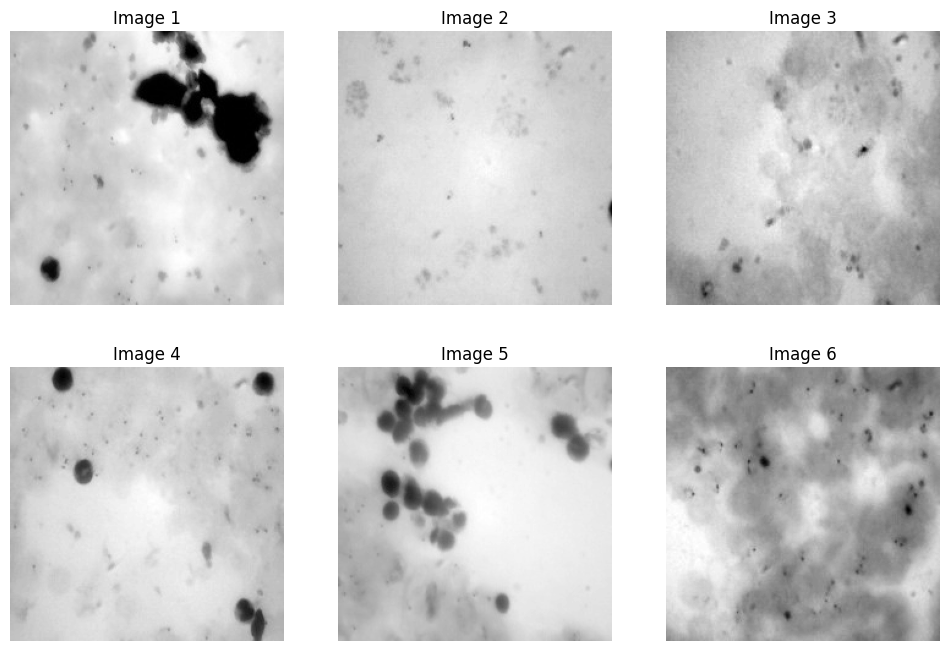

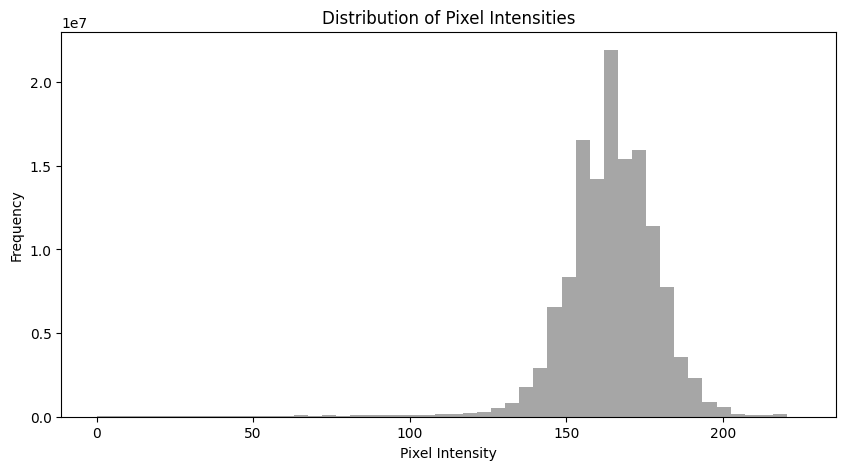

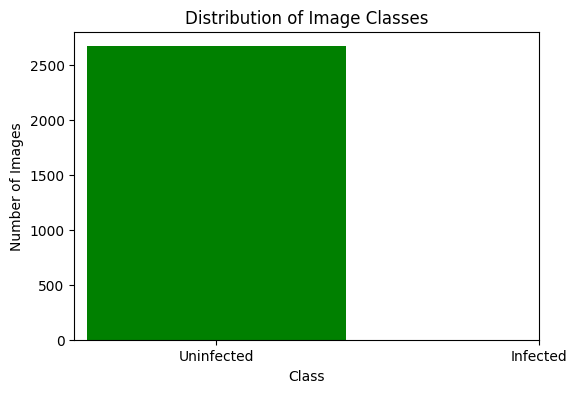

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Specify the path to your resized dataset
resized_dataset_path = "/content/drive/MyDrive/normalized_images/"

# Function to load an image
def load_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# List all images in the resized dataset
image_paths = [os.path.join(resized_dataset_path, f) for f in os.listdir(resized_dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Display basic information about the resized dataset
print(f"Number of resized images: {len(image_paths)}")

# Display a few sample images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(6):
    img = load_image(image_paths[i])
    axes[i // 3, i % 3].imshow(img, cmap='gray')
    axes[i // 3, i % 3].axis('off')
    axes[i // 3, i % 3].set_title(f"Image {i+1}")

plt.show()

# Display the distribution of pixel intensities
pixel_intensities = [img.flatten() for img in (load_image(img_path) for img_path in image_paths)]
pixel_intensities = np.concatenate(pixel_intensities)

plt.figure(figsize=(10, 5))
plt.hist(pixel_intensities, bins=50, color='gray', alpha=0.7)
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Display the distribution of image classes (assuming binary classification)
# Modify this part based on your dataset structure
image_classes = [1 if 'infected' in img_path.lower() else 0 for img_path in image_paths]
class_distribution = Counter(image_classes)

plt.figure(figsize=(6, 4))
plt.bar(class_distribution.keys(), class_distribution.values(), color=['green', 'red'])
plt.title('Distribution of Image Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks([0, 1], ['Uninfected', 'Infected'])
plt.show()


In [ ]:
pip install numpy matplotlib opencv-python scikit-learn

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

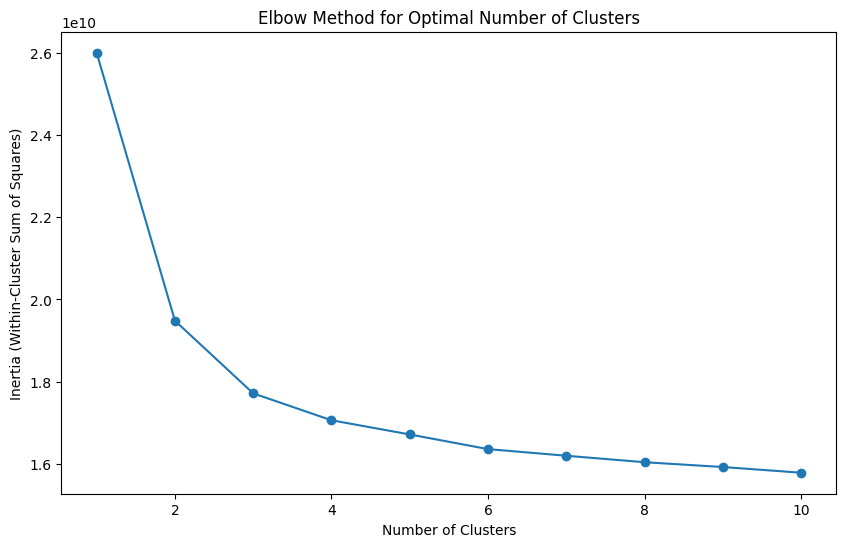

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


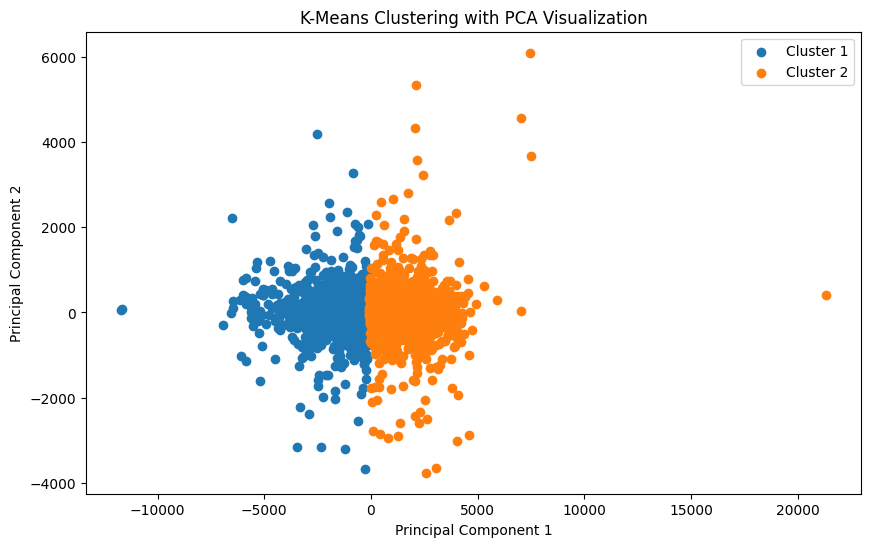

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Specify the path to your resized dataset
resized_dataset_path = "/content/drive/MyDrive/normalized_images/train"

# Function to load an image
def load_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# List all images in the resized dataset
image_paths = [os.path.join(resized_dataset_path, f) for f in os.listdir(resized_dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Load all images into a list
images = [load_image(img_path) for img_path in image_paths]

# Flatten each image to create a list of flattened images
flattened_images = [img.flatten() for img in images]

# Convert the list of flattened images to a NumPy array
image_matrix = np.array(flattened_images)

# Elbow Method to determine the optimal number of clusters
inertia_values = []
possible_clusters = range(1, 11)  # Try different numbers of clusters
for num_clusters in possible_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(image_matrix)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(possible_clusters, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

# Choose the optimal number of clusters based on the elbow method
# The optimal number of clusters is where the inertia starts to decrease at a slower rate
optimal_num_clusters = 2  # Adjust based on the elbow method plot

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
labels = kmeans.fit_predict(image_matrix)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(image_matrix)

# Visualize the clustered data
plt.figure(figsize=(10, 6))

# Plot points with different colors based on their cluster assignment
for i in range(optimal_num_clusters):
    cluster_points = reduced_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

plt.title('K-Means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
``

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from shutil import copyfile

# Specify the path to your resized dataset
resized_dataset_path = "/content/drive/MyDrive/normalized_images/"

# Function to load an image
def load_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# List all images in the resized dataset
image_paths = [os.path.join(resized_dataset_path, f) for f in os.listdir(resized_dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Load all images into a list
images = [load_image(img_path) for img_path in image_paths]

# Flatten each image to create a list of flattened images
flattened_images = [img.flatten() for img in images]

# Convert the list of flattened images to a NumPy array
image_matrix = np.array(flattened_images)

# Optimal number of clusters determined from the elbow method or your choice
optimal_num_clusters = 2

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
labels = kmeans.fit_predict(image_matrix)

# Create directories for each cluster
output_dir = "/content/drive/MyDrive/clustered_images/"
cluster_sizes = []

for i in range(optimal_num_clusters):
    cluster_dir = os.path.join(output_dir, f"cluster_{i + 1}")
    os.makedirs(cluster_dir, exist_ok=True)

    # Move all images to their respective cluster folders and count the number of images
    cluster_size = 0
    for img_path, label in zip(image_paths, labels):
        if label == i:
            cluster_size += 1
            img_name = os.path.basename(img_path)
            output_path = os.path.join(cluster_dir, img_name)
            copyfile(img_path, output_path)

    cluster_sizes.append(cluster_size)
    print(f"Cluster {i + 1}: {cluster_size} images")

# Display the total number of images in the two clusters
total_images = sum(cluster_sizes)
print(f"\nTotal Number of Images in the Two Clusters: {total_images}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1: 1261 images
Cluster 2: 1412 images

Total Number of Images in the Two Clusters: 2673


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1: 1257 images
Cluster 2: 1422 images

Total Number of Images in the Two Clusters: 2679


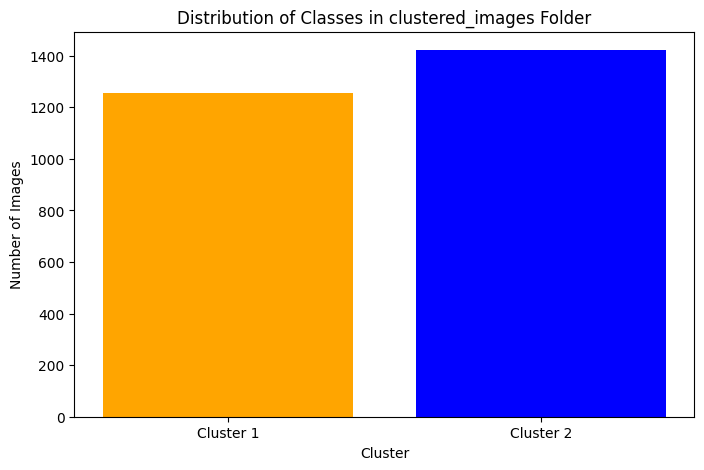

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from shutil import copyfile
import matplotlib.pyplot as plt
from collections import Counter

# Specify the path to your resized dataset
resized_dataset_path = "/content/drive/MyDrive/resized_images/"

# Function to load an image
def load_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# List all images in the resized dataset
image_paths = [os.path.join(resized_dataset_path, f) for f in os.listdir(resized_dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Load all images into a list
images = [load_image(img_path) for img_path in image_paths]

# Flatten each image to create a list of flattened images
flattened_images = [img.flatten() for img in images]

# Convert the list of flattened images to a NumPy array
image_matrix = np.array(flattened_images)

# Optimal number of clusters determined from the elbow method or your choice
optimal_num_clusters = 2

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
labels = kmeans.fit_predict(image_matrix)

# Create directories for each cluster
output_dir = "/content/drive/MyDrive/clustered_images/"
cluster_sizes = []

for i in range(optimal_num_clusters):
    cluster_dir = os.path.join(output_dir, f"cluster_{i + 1}")
    os.makedirs(cluster_dir, exist_ok=True)

    # Move all images to their respective cluster folders and count the number of images
    cluster_size = 0
    for img_path, label in zip(image_paths, labels):
        if label == i:
            cluster_size += 1
            img_name = os.path.basename(img_path)
            output_path = os.path.join(cluster_dir, img_name)
            copyfile(img_path, output_path)

    cluster_sizes.append(cluster_size)
    print(f"Cluster {i + 1}: {cluster_size} images")

# Display the total number of images in the two clusters
total_images = sum(cluster_sizes)
print(f"\nTotal Number of Images in the Two Clusters: {total_images}")

# Visualize the distribution of classes in the clustered_images folder
class_distribution = Counter(labels)

plt.figure(figsize=(8, 5))
plt.bar(class_distribution.keys(), class_distribution.values(), color=['blue', 'orange'])
plt.title('Distribution of Classes in clustered_images Folder')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.xticks(range(optimal_num_clusters), [f'Cluster {i+1}' for i in range(optimal_num_clusters)])
plt.show()


In [1]:
!pip install shap
import os
import cv2
import numpy as np
!pip install scikit-image

In [2]:
dataset_path = '/content/drive/My Drive/clustered_images'

In [3]:
import os
import numpy as np
import shap
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
image_paths = []
labels = []

In [6]:

for folder in os.listdir(dataset_path):
    if folder.startswith('cluster'):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(dataset_path, folder, file))
                labels.append(folder)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Load images and preprocess them
images = []
successful_indices = []

for i, path in enumerate(image_paths):
    try:
        img = Image.open(path)
        img = img.resize((224, 224))  # Adjust the size as needed
        img_array = np.array(img)
        images.append(img_array)
        successful_indices.append(i)
    except Exception as e:
        print(f"Error processing image at path {path}: {e}")

# Convert the list of images to a NumPy array
X = np.array(images)

# Filter labels based on successful indices
filtered_labels = [encoded_labels[index] for index in successful_indices]
filtered_labels_np = np.array(filtered_labels)
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, filtered_labels_np, test_size=0.2, random_state=42)



In [7]:

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(encoded_labels)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = np.argmax(model.predict(X_val), axis=1)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on the validation set: {accuracy}")


Epoch 1/5
68/68 [==============================] - 107s 2s/step - loss: 156.4507 - accuracy: 0.5156 - val_loss: 0.7051 - val_accuracy: 0.5475
Epoch 2/5
68/68 [==============================] - 108s 2s/step - loss: 0.6222 - accuracy: 0.6404 - val_loss: 0.7041 - val_accuracy: 0.5680
Epoch 3/5
68/68 [==============================] - 109s 2s/step - loss: 0.5004 - accuracy: 0.7084 - val_loss: 0.9440 - val_accuracy: 0.5493
Epoch 4/5
68/68 [==============================] - 110s 2s/step - loss: 0.3919 - accuracy: 0.7769 - val_loss: 1.4183 - val_accuracy: 0.5270
Epoch 5/5
17/17 [==============================] - 8s 489ms/step
Accuracy on the validation set: 0.5381750465549349


In [ ]:
# SHAP explainer
explainer = shap.Explainer(model, masker=shap.maskers.Image(X_val))
image_index = 0
shap_values = explainer.shap_values(X_val[image_index])

shap.image_plot(shap_values, X_val[image_index])

plt.savefig('/content/drive/MyDrive/shap_image_plot.png')
plt.show()
